## Analyse and Visualize TDS articles

Within this notebook I am analysing the data I scraped and saved in the postgres database.

## Connect to database

In [1]:
import os
import psycopg2

def connect_postgres():
    conn = psycopg2.connect(
        host="localhost",
        database="medium",
        user="postgres",
        password=os.environ['Postgres_secret'])

    return conn

conn = connect_postgres()

# Create a cursor to perform database operations
cursor = conn.cursor()

In [2]:
# Formating visualization
yellow_theme = (243/255, 210/255, 58/255)
grey_theme = (153/255, 153/255, 153/255)
black_theme = (0/255, 0/255, 0/255)
blue_theme = (0.2, 0.4, 0.6, 0.6)

## Article History 

In [22]:
published_articles_per_year =   """
                                SELECT date_part('year', published), avg(clap_count), count(clap_count), avg(voter_count)
                                FROM public.scraper_articles
                                group by date_part('year', published)
                                ORDER BY date_part('year', published)
                                """

In [20]:
import pandas as pd

# get count of articles published each year
articles_history = pd.read_sql_query(published_articles_per_year,con=conn)
articles_history.head(5)

,date_part,avg,count,avg
0,2010.0,27.000000,1,NaN
1,2011.0,5.000000,1,NaN
2,2013.0,180.000000,1,NaN
3,2014.0,86.500000,2,NaN
4,2015.0,126.441176,34,NaN


<IPython.core.display.Javascript object>


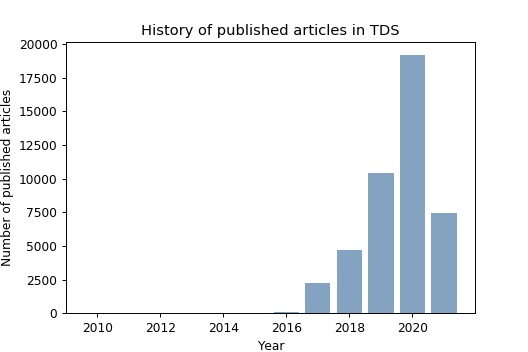

In [21]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4), dpi=80)

p1 = plt.bar(articles_history.date_part,articles_history["count"], color=blue_theme)

plt.ylabel('Number of published articles')
plt.xlabel('Year')
plt.title('History of published articles in TDS')

plt.show()

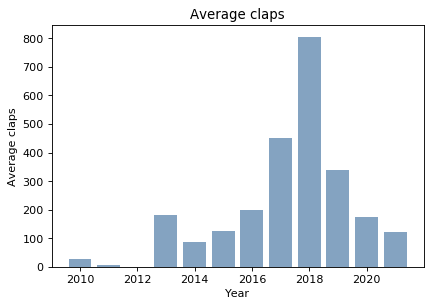

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4), dpi=80)

p1 = plt.bar(articles_history.date_part,articles_history.avg, color=blue_theme)

plt.ylabel('Average claps')
plt.xlabel('Year')
plt.title('Average claps')

plt.show()

## Difference between claps and voters

- Does the voter_claps_ratio depend on the number of claps in total?

In [7]:
difference_claps_voters = """
SELECT 	*, 
        voter_count/clap_count as voter_claps_ratio 
FROM public.scraper_articles
where voter_count is not Null and clap_count is not Null and voter_count > 0 and clap_count > 0
order by voter_claps_ratio DESC
"""

In [8]:
difference_claps_voters_histo = """
select
  floor(voter_count/5)*5 as bin_floor, 
  avg(voter_claps_ratio) as voter_claps_ratio_avg,
  avg(clap_count) as clap_count_avg
from 
(
	SELECT 	*, 
			clap_count/voter_count as voter_claps_ratio 
	FROM public.scraper_articles
	where voter_count is not Null and clap_count is not Null and voter_count > 0 and clap_count > 0
)
AS x 
group by bin_floor
order by 1;
"""

In [9]:
import pandas as pd

# calc voter_claps_ratio
voter_claps_ratio = pd.read_sql_query(difference_claps_voters_histo,con=conn)
voter_claps_ratio.head(5)

,bin_floor,voter_claps_ratio_avg,clap_count_avg
0,0.0,8.851444,21.373715
1,5.0,5.759319,42.701103
2,10.0,5.537959,71.027425
3,15.0,5.492173,100.221966
4,20.0,5.176150,123.920273


<IPython.core.display.Javascript object>


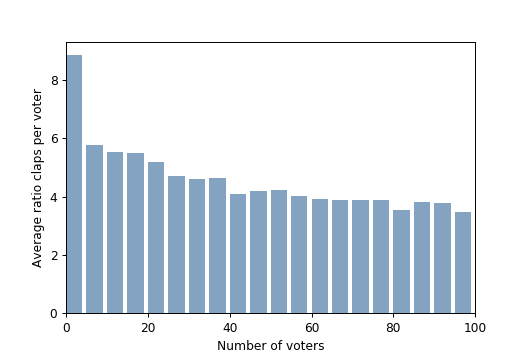

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

plt.figure(figsize=(6, 4), dpi=80)

p1 = plt.bar([int(item) for item in voter_claps_ratio["bin_floor"]],
              voter_claps_ratio["voter_claps_ratio_avg"],
              width = 4,
              align = 'edge',
              color=blue_theme)

plt.ylabel('Average ratio claps per voter')
plt.xlabel('Number of voters')
plt.xlim(0,100)
plt.savefig("ratio_claps_per_voter_1.svg")

# plt.title('Average claps')

plt.show()

In [17]:
difference_claps_voters_histo_2 = """
select
  floor(voter_count/100)*100 as bin_floor, 
  avg(voter_claps_ratio) as voter_claps_ratio_avg,
  avg(clap_count) as clap_count_avg
from 
(
	SELECT 	*, 
			clap_count/voter_count as voter_claps_ratio 
	FROM public.scraper_articles
	where voter_count is not Null and clap_count is not Null and voter_count > 0 and clap_count > 0
)
AS x 
group by bin_floor
order by 1;
"""

import pandas as pd

# calc voter_claps_ratio
voter_claps_ratio_2 = pd.read_sql_query(difference_claps_voters_histo_2,con=conn)
voter_claps_ratio_2.head(5)

,bin_floor,voter_claps_ratio_avg,clap_count_avg
0,0.0,5.505132,118.335363
1,100.0,3.453940,549.809094
2,200.0,3.448276,953.773081
3,300.0,3.349010,1323.650990
4,400.0,3.382353,1735.806723


<IPython.core.display.Javascript object>


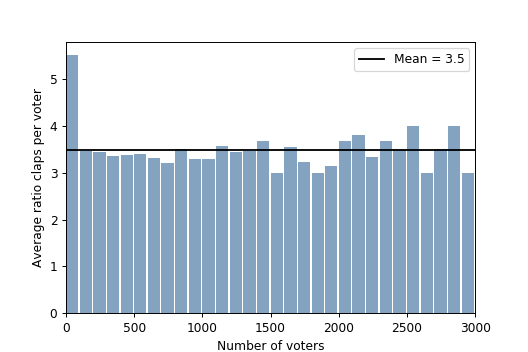

In [25]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

plt.figure(figsize=(6, 4), dpi=80)

# calculate overall average
from statistics import mean
average = mean(voter_claps_ratio_2["voter_claps_ratio_avg"])
voter_claps_ratio_2["overall_average"] = [average for item in voter_claps_ratio_2["bin_floor"]]

p1 = plt.bar([int(item) for item in voter_claps_ratio_2["bin_floor"]],
              voter_claps_ratio_2["voter_claps_ratio_avg"],
              width = 90,
              align = 'edge',
              color=blue_theme)

p1 = plt.plot([int(item) for item in voter_claps_ratio_2["bin_floor"]],
              voter_claps_ratio_2["overall_average"], 
              label='Mean = ' + str(round(average,1)),
             color = "black")

plt.ylabel('Average ratio claps per voter')
plt.xlabel('Number of voters')
plt.xlim(0,3000)
plt.legend()

plt.savefig("ratio_claps_per_voter_2.svg")

# plt.title('Average claps')

plt.show()

## Has the Clap_Voter_Ratio changed over time?

In [28]:
difference_claps_voters_change = """
SELECT 	date_part('year', published), avg(clap_count/voter_count) as voter_claps_ratio 
FROM public.scraper_articles
where voter_count is not Null and clap_count is not Null and voter_count > 0 and clap_count > 0

group by date_part('year', published)
ORDER BY date_part('year', published)

"""

import pandas as pd

# calc voter_claps_ratio
voter_claps_ratio_change = pd.read_sql_query(difference_claps_voters_change,con=conn)
voter_claps_ratio_change.head(5)

,date_part,voter_claps_ratio
0,2017.0,3.384407
1,2018.0,4.982387
2,2019.0,5.165103
3,2020.0,5.235891
4,2021.0,6.086693


<IPython.core.display.Javascript object>


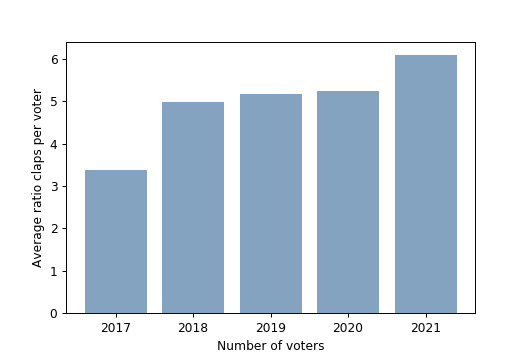

In [35]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

plt.figure(figsize=(6, 4), dpi=80)

p1 = plt.bar([int(item) for item in voter_claps_ratio_change["date_part"]],
              voter_claps_ratio_change["voter_claps_ratio"],
              width = 0.8,
              align = 'center',
              color=blue_theme)

plt.ylabel('Average ratio claps per voter')
plt.xlabel('Number of voters')
plt.savefig("ratio_claps_per_voter_1.svg")

# plt.title('Average claps')

plt.show()